# Data Assimilation with GPS Data

This project demonstrates the Ensemble Kalman Filter (EnKF) using real GPS data procured from two phones measuring the location of the same thing (me driving my car around a parking lot). It is meant as a hands-on experience in overcoming each obstacle of real-world data assimilation, including asynchronous and irregularly-spaced observations that don't directly map to the timing of the state model, and obtaining a solid initial $\mathbf{R}$ matrix. The second issue is determining the accuracy of the model - for my case, I was able to make an approximate "true" solution by mapping out my route using an online tool. 

<img src = "../img/routes.png" height = 300 width = 300/>

## Plotting the data

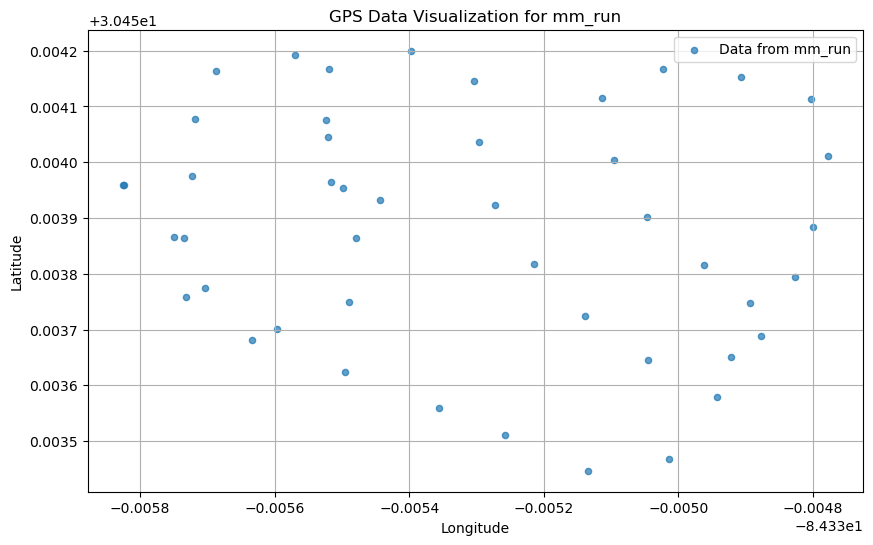

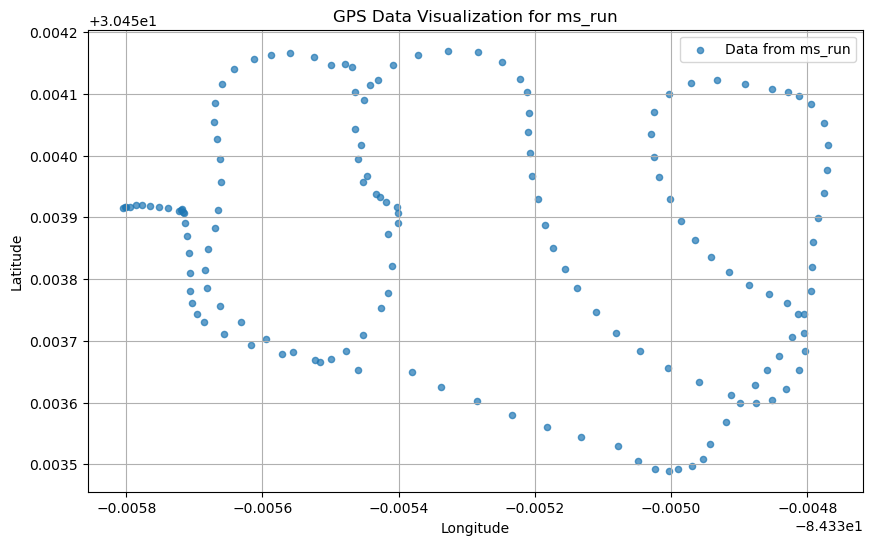

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_gps_data(file_path, data_format):
    # Load data
    data = pd.read_csv(file_path)
    
    # Check the data format and extract coordinates
    if data_format == 'mm_run':
        # Assuming 'lat' and 'long' columns for Maddison's phone data
        latitudes = data['Y']
        longitudes = data['X']
    elif data_format == 'ms_run':
        # Assuming 'latitude' and 'longitude' columns for Mario's phone data
        latitudes = data['Latitude']
        longitudes = data['Longitude']
    else:
        raise ValueError("Data format not recognized")
    
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(longitudes, latitudes, alpha=0.7, marker='o', s=20, label=f'Data from {data_format}')
    plt.title(f'GPS Data Visualization for {data_format}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.legend()
    plt.show()

# Paths to the datasets
mm_file_path = '../data/True_Run_maddisons_phone.csv'
ms_file_path = '../data/true_run_marios_phone.csv'

# Plotting each dataset
plot_gps_data(mm_file_path, 'mm_run')
plot_gps_data(ms_file_path, 'ms_run')


## Interpolating the observations

Data after resampling and interpolation for mm_run with frequency 5s:
                      X   Y  Time(sec)  Latitude  Longitude  \
datetime                                                      
2024-04-25 01:28:10 NaN NaN        NaN       NaN        NaN   
2024-04-25 01:28:15 NaN NaN        NaN       NaN        NaN   
2024-04-25 01:28:20 NaN NaN        NaN       NaN        NaN   
2024-04-25 01:28:25 NaN NaN        NaN       NaN        NaN   
2024-04-25 01:28:30 NaN NaN        NaN       NaN        NaN   
2024-04-25 01:28:35 NaN NaN        NaN       NaN        NaN   
2024-04-25 01:28:40 NaN NaN        NaN       NaN        NaN   
2024-04-25 01:28:45 NaN NaN        NaN       NaN        NaN   
2024-04-25 01:28:50 NaN NaN        NaN       NaN        NaN   
2024-04-25 01:28:55 NaN NaN        NaN       NaN        NaN   

                     Horizontal Accuracy(m)  Altitude(m)  \
datetime                                                   
2024-04-25 01:28:10                     NaN          

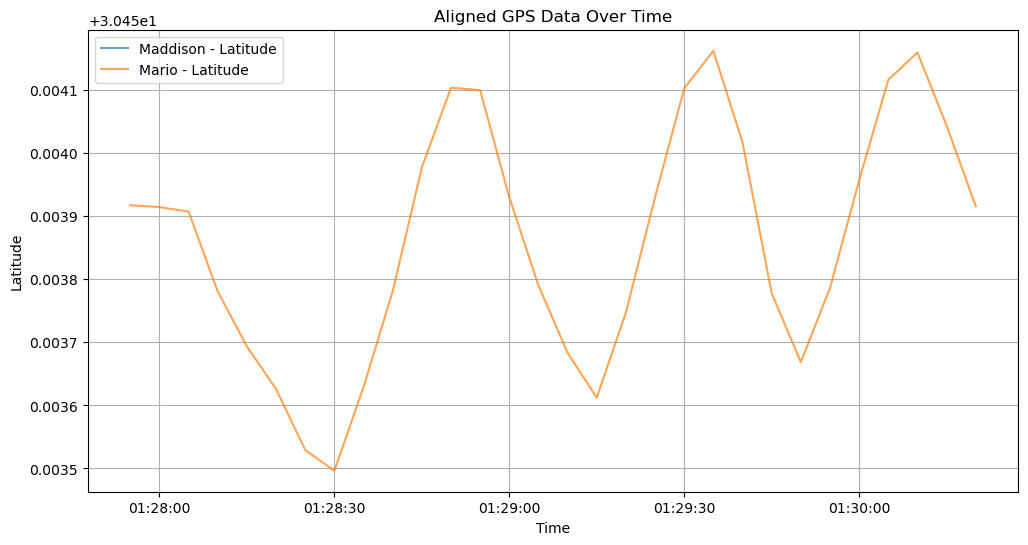

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def interpolate_gps_data(file_path, data_format, freq='5s'):  # Adjusting frequency to 5 seconds
    # Load data
    data = pd.read_csv(file_path)
    
    # Parse the datetime and set as index
    if data_format == 'mm_run':
        data['datetime'] = pd.to_datetime(data['Date(GMT)']) + pd.to_timedelta(data['Time(sec)'], unit='s')
        data.set_index('datetime', inplace=True)
        data[['Y', 'X']] = data[['Y', 'X']].apply(pd.to_numeric, errors='coerce')
    elif data_format == 'ms_run':
        data['datetime'] = pd.to_datetime(data['time'])
        data.set_index('datetime', inplace=True)
        data[['Latitude', 'Longitude']] = data[['Latitude', 'Longitude']].apply(pd.to_numeric, errors='coerce')
    else:
        raise ValueError("Data format not recognized")
    
    data_numeric = data.select_dtypes(include=[np.number])
    data_resampled = data_numeric.resample(freq).interpolate()
    
    print(f"Data after resampling and interpolation for {data_format} with frequency {freq}:")
    print(data_resampled.head(10))  # Show more rows to better understand the output

    return data_resampled

# Try with a finer resampling frequency
madds_resampled = interpolate_gps_data(mm_file_path, 'mm_run')
marios_resampled = interpolate_gps_data(ms_file_path, 'ms_run')

# Plotting interpolated data
plt.figure(figsize=(12, 6))
plt.plot(madds_resampled.index, madds_resampled['Y'], label='Maddison - Latitude', alpha=0.7)
plt.plot(marios_resampled.index, marios_resampled['Latitude'], label='Mario - Latitude', alpha=0.7)
plt.title('Aligned GPS Data Over Time')
plt.xlabel('Time')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()
